Use PyTorch, GPU and Colab.

Implement a simple convolutional neural network with training and validation on CIFAR10 dataset, limited to subset of 3k train and 3k test images.
Train the neural network for ~30 epochs with Adam optimizer and batch size equal to 64. Implement validation on batches.
  
Code the following incrementally:
- Prevent overfitting using a) dropout and b) data augmentation.
- Add test augmentation.
- For better results use transfer learning.

In [106]:
import torch
torch.manual_seed(0)
 
import random
random.seed(0)
 
import numpy as np
np.random.seed(0)
 
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import pickle

transform = transforms.Compose( [ transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) ] )
 
batch_size = 64
num_workers = 0
path = 'data/cifar-10-batches-py/'
RESTRICTED_LEN = 3e3 * 2

import os
import pandas as pd
from torchvision.io import decode_image 
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm import tqdm


In [107]:
def unpickle(file):
    with open(path + file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict 

batch1 = unpickle('data_batch_1')
meta = unpickle('batches.meta')
 
for i, (key, val) in enumerate(batch1.items()):
    print(i)
    print(key)
    print(val)

for i, (key, val) in enumerate(meta.items()):
    print(i)
    print(key)
    print(val)

0
b'batch_label'
b'training batch 1 of 5'
1
b'labels'
[6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1, 8, 3, 9, 6, 6, 1, 8, 5, 2, 9, 9, 8, 1, 7, 7, 0, 0, 6, 9, 1, 2, 2, 9, 2, 6, 6, 1, 9, 5, 0, 4, 7, 6, 7, 1, 8, 1, 1, 2, 8, 1, 3, 3, 6, 2, 4, 9, 9, 5, 4, 3, 6, 7, 4, 6, 8, 5, 5, 4, 3, 1, 8, 4, 7, 6, 0, 9, 5, 1, 3, 8, 2, 7, 5, 3, 4, 1, 5, 7, 0, 4, 7, 5, 5, 1, 0, 9, 6, 9, 0, 8, 7, 8, 8, 2, 5, 2, 3, 5, 0, 6, 1, 9, 3, 6, 9, 1, 3, 9, 6, 6, 7, 1, 0, 9, 5, 8, 5, 2, 9, 0, 8, 8, 0, 6, 9, 1, 1, 6, 3, 7, 6, 6, 0, 6, 6, 1, 7, 1, 5, 8, 3, 6, 6, 8, 6, 8, 4, 6, 6, 1, 3, 8, 3, 4, 1, 7, 1, 3, 8, 5, 1, 1, 4, 0, 9, 3, 7, 4, 9, 9, 2, 4, 9, 9, 1, 0, 5, 9, 0, 8, 2, 1, 2, 0, 5, 6, 3, 2, 7, 8, 8, 6, 0, 7, 9, 4, 5, 6, 4, 2, 1, 1, 2, 1, 5, 9, 9, 0, 8, 4, 1, 1, 6, 3, 

In [108]:
def cifar_show(vec):
    # img = img / 2 + 0.5     # unnormalize
    print(vec.shape)
    # for c in range(32):
        # for r in range(32):
            # for color in range(3):

    vec = vec.reshape(3, 32, 32)
    vec = vec.transpose((2,1,0))
    print(vec)
    plt.imshow(vec)
    plt.show()
    assert False

In [109]:
class CIFAR10Dataset(Dataset):
    def unpickle(self, file):
        with open(self.path + file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict 

    def __init__(self, path, meta_file, img_dirs, transform=None, target_transform=None):
        self.path = path        

        meta = self.unpickle(meta_file)
        
        self.labels = meta[b'label_names'] 
        self.labels = [bs.decode("utf-8") for bs in self.labels]

        self.batch_size = meta[b'num_cases_per_batch']

        self.img_dir = os.path.join(path, f'../{img_dirs[0][:4]}_imgs')
        if not os.path.exists(self.img_dir):
            os.makedirs(self.img_dir) 

        self.img_labels = []

        for i, dir in enumerate(img_dirs):
            batch = self.unpickle(dir)
            self.img_labels += batch[b'labels'] 

            for j, img in tqdm(enumerate(batch[b'data']), total = self.batch_size, desc = f"batch_{i+1}"):

                img_path = os.path.join(self.img_dir, f'img{i * self.batch_size + j}.npy')
                if not os.path.exists(img_path):
                    np.save(img_path, np.array(img))
                
        self.transform = transform
        self.target_transform = target_transform

In [128]:
from torchvision.transforms import v2

def cifar_augment(self):
    augment = v2.Compose([
        ToTensor(), 
        v2.RandomResizedCrop(size=(224, 224), antialias=True),
        v2.RandomHorizontalFlip(p=0.8),
        v2.Resize(size=(32, 32)),
    ])

    rng = int(RESTRICTED_LEN / 2)
    for j in tqdm(range(rng), total = rng, desc = f"augment"):

        img_path = os.path.join(self.img_dir, f'img{j}.npy')
        new_img_path = os.path.join(self.img_dir, f'img{j + rng}.npy')

        if os.path.exists(img_path):
            image = np.load(img_path)
            image = image.reshape(3, 32, 32)
            image = augment(image)

            np.save(new_img_path, np.array(image))

            cifar_show(image)

CIFAR10Dataset._augment = cifar_augment

In [129]:
def cifar__len__(self):
    if len(self.img_labels) > 10_000:
        return RESTRICTED_LEN
    else:
        return len(self.img_labels)

CIFAR10Dataset.__len__ = cifar__len__

def cifar__getitem__(self, idx):
    img_path = os.path.join(self.img_dir, f'img{idx}.npy')

    # image = decode_image(img_path)
    image = np.load(img_path)
    image = image.reshape(3, 32, 32)
    image = image.transpose((1, 2, 0))

    label = self.img_labels[idx]

    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)

    return image, label

CIFAR10Dataset.__getitem__ = cifar__getitem__

In [130]:
def create_loader(path: str, train: bool, transform) -> torch.utils.data.DataLoader:
    if train:
        train_dirs = [f'data_batch_{i}' for i in range(1,6)] 

        training_data = CIFAR10Dataset(
            path,
            'batches.meta',
            train_dirs,
            transform = transform,
        )

        training_data._augment()

        return DataLoader(training_data, batch_size=64, shuffle=True)

    else:
        test_dirs = ['test_batch'] 
        test_data = CIFAR10Dataset(
            path,
            'batches.meta',
            test_dirs,
            transform = transform,
            )
        return DataLoader(test_data, batch_size=64, shuffle=True)

transform_tr =  transform
transform_val = transform

trainloader = create_loader(path, train=True, transform=transform_tr)
testloader = create_loader(path, train=False, transform=transform_val)

batch_1:   0%|          | 0/10000 [00:00<?, ?it/s]

augment:   0%|          | 0/3000 [00:00<?, ?it/s]/tmp/ipykernel_20178/2115805243.py:22: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  np.save(new_img_path, np.array(image))
augment:   0%|          | 0/3000 [00:00<?, ?it/s]


torch.Size([32, 32, 32])


RuntimeError: shape '[3, 32, 32]' is invalid for input of size 32768

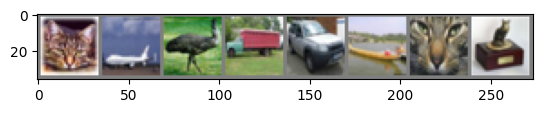

    cat     plane   bird    truck   car     ship    cat     cat    


In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# sample data
display_limit = 8
 
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
 
# get some random training images
print(trainloader)
dataiter = iter(trainloader)
print(dataiter)
images, labels = next(dataiter)
 
# show images
imshow(torchvision.utils.make_grid(images[:display_limit]))
# print labels
print('    ' + ' '.join(f'{classes[labels[j]]:7s}' for j in range(display_limit)))

In [ ]:
class Dropout(torch.nn.Module):
    def __init__(self, p=0.95):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        dropout = torch.Tensor(x.shape)
        dropout.bernoulli_(p = self.p)
        new_x = x * dropout

        return new_x * (1/self.p)

In [ ]:
W, H = 32, 32
Ch = 3
 
# should have conv 32, conv 64, conv 128 (all with kernel size 3x3, stride 2 and padding 1) with relu activations, hidden linear layer 40 with relu, and linear output
class ConvNet(nn.Module): 
    def __init__(self, init_W, init_H, init_Ch, linear_constructor):
        self._linear_constructor = linear_constructor
        super(ConvNet, self).__init__()
        args = {'kernel_size': 3, 'stride': 2, 'padding': 1}

        self.conv1 = nn.Conv2d(init_Ch, 32, **args)
        self.conv2 = nn.Conv2d(32, 64, **args)
        self.conv3 = nn.Conv2d(64, 128, **args)

        self.relu = nn.ReLU()

        self.dp = Dropout(p = 0.9)

        assert init_H == init_W, 'Dimensions should match' 
        self.hidden_layer_input_dim = int((init_W / 8)**2 * 128)

        self.fc1 = nn.Linear(self.hidden_layer_input_dim, 40)
        self.fc2 = nn.Linear(40, 10)

    def forward(self, x):
        for m in [self.conv1, self.conv2, self.conv3]:
            x = self.relu(m(x))
            if self.training:
                x = self.dp(x)

        x = x.view(-1, self.hidden_layer_input_dim)
        x = self.relu(self.fc1(x))

        return self.fc2(x)

In [ ]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

class NetTrainer(object):
    def __init__(self, trainloader, testloader):
        self.trainloader = trainloader 
        self.testloader = testloader

    def train(self, net, device, epochs = 20, lr = 1e-3):
        writer = SummaryWriter('data/tensorboard_logs')
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr = lr)

        for epoch in range(epochs):
            running_loss = 0.0
            for i, data in enumerate(self.trainloader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                if i % 100 == 99:
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 100))
                    writer.add_scalar('Loss', running_loss)
                    running_loss = 0.0

            correct = 0
            total = 0
            with torch.no_grad():
                for data in self.testloader:
                    images, labels = data
                    images, labels = images.to(device), labels.to(device)
                    outputs = net(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the {} test images: {} %'.format(
                total, 100 * correct / total))
            writer.add_scalar('Accuracy', running_loss)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

epochs = 40
net = ConvNet(W, H, Ch, None).to(device)

trainer = NetTrainer(trainloader, testloader)
trainer.train(net, device, epochs)

In [ ]:
PATH = 'data/cifar_net.pth'

def save_net(path, net):
    torch.save(net.state_dict(), path)

save_net(PATH, net)

In [ ]:
def load_params(path, net):
    net.load_state_dict(torch.load(path, weights_only = True))
    net.eval()
    return net

net = load_params(PATH, net)

In [ ]:
def validate(loader, name):
  #TODO
 
validate(trainloader, "train")
validate(testloader, "test")

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir runs